In [6]:
# SETUP

import os
import traceback
import numpy as np
import time
import matplotlib.pyplot as plt
#from cuda import cuda, nvrtc

from hyperbolicTSNE.util import find_last_embedding
from hyperbolicTSNE.visualization import plot_poincare, animate
from hyperbolicTSNE import load_data, Datasets, SequentialOptimizer, initialization, HyperbolicTSNE
from hyperbolicTSNE.quality_evaluation_ import hyperbolic_nearest_neighbor_preservation


data_home = "datasets"
log_path = "temp/poincaregpu/"  # path for saving embedding snapshots

only_animate = False
seed = 42
dataset = Datasets.MNIST  # the Datasets handler provides access to several data sets used throughout the repository
perp = 15  # we use a perplexity of 30 in this example
logging = True

In [2]:

def run(num_points = 1000, exact=False, use_uniform_grid=False, uniform_grid_n=10):
    global logging
    global log_path

    dataX, dataLabels, D, V, _ = load_data(
        dataset, 
        data_home=data_home, 
        random_state=seed, 
        to_return="X_labels_D_V",
        hd_params={"perplexity": perp}, 
        sample=num_points, 
        knn_method="hnswlib"  # we use an approximation of high-dimensional neighbors to speed up computations
    )

    print("Loading data")

    start_time = time.time()


    end_time = time.time()

    execution_time = end_time - start_time
    print("Data loading:", execution_time, "seconds")

    exaggeration_factor = 12  # Just like regular t-SNE, we use early exaggeration with a factor of 12
    learning_rate = (dataX.shape[0] * 1) / (exaggeration_factor * 1000)  # We adjust the learning rate to the hyperbolic setting
    ex_iterations = 250  # The embedder is to execute 250 iterations of early exaggeration, ...
    main_iterations = 750  # ... followed by 750 iterations of non-exaggerated gradient descent.



    # ============= RUNNING =============

    opt_config = dict(
        learning_rate_ex=learning_rate,  # learning rate during exaggeration
        learning_rate_main=learning_rate,  # learning rate main optimization 
        exaggeration=exaggeration_factor, 
        exaggeration_its=ex_iterations, 
        gradientDescent_its=main_iterations, 
        vanilla=False,  # if vanilla is set to true, regular gradient descent without any modifications is performed; for  vanilla set to false, the optimization makes use of momentum and gains
        momentum_ex=0.5,  # Set momentum during early exaggeration to 0.5
        momentum=0.8,  # Set momentum during non-exaggerated gradient descent to 0.8
        exact=exact,  # To use the quad tree for acceleration (like Barnes-Hut in the Euclidean setting) or to evaluate the gradient exactly
        area_split=False,  # To build or not build the polar quad tree based on equal area splitting or - alternatively - on equal length splitting
        n_iter_check=10,  # Needed for early stopping criterion
        size_tol=0.999,  # Size of the embedding to be used as early stopping criterion
        uniform_grid_n = uniform_grid_n,
        use_uniform_grid = use_uniform_grid
    )

    opt_params = SequentialOptimizer.sequence_poincare(**opt_config)

    #print("Sequence defined")

    # Start: configure logging
    if logging:
        logging_dict = {
            "log_path": log_path
        }
        opt_params["logging_dict"] = logging_dict

        log_path = opt_params["logging_dict"]["log_path"]
        # Delete old log path
        if os.path.exists(log_path) and not only_animate:
            import shutil
            shutil.rmtree(log_path)
    # End: logging

    # Compute an initial embedding of the data via PCA
    X_embedded = initialization(
        n_samples=dataX.shape[0],
        n_components=2,
        X=dataX,
        random_state=seed,
        method="pca"
    )

    # Initialize the embedder
    htsne = HyperbolicTSNE(
        init=X_embedded, 
        n_components=2, 
        metric="precomputed", 
        verbose=True, 
        opt_method=SequentialOptimizer, 
        opt_params=opt_params
    )

    start_time = time.time()

    try:
        hyperbolicEmbedding = htsne.fit_transform((D, V))
    except ValueError:
        print("Error!")
        hyperbolicEmbedding = find_last_embedding(log_path)
        traceback.print_exc()

    end_time = time.time()

    execution_time = end_time - start_time
    if exact:
        if use_uniform_grid:
            print(f"[CPU Exact, n={num_points}] Execution time:", execution_time, "seconds")
        else:
            print(f"[GPU Exact, n={num_points}] Execution time:", execution_time, "seconds")
    elif use_uniform_grid:
        print(f"[UGrid, n={num_points}, grid_n={uniform_grid_n}] Execution time:", execution_time, "seconds")
    else:
        print(f"[QTree, n={num_points}] Execution time:", execution_time, "seconds")

        
    _, precisions, recalls, _ = hyperbolic_nearest_neighbor_preservation(
        dataX,
        hyperbolicEmbedding,
        k_start=1,
        k_max=30,
        D_X=None,
        exact_nn=True,
        consider_order=False,
        strict=False,
        to_return="full"
    )

    print(f"Precision: {precisions}, recall: {recalls}")

    # Create a rendering of the embedding and save it to a file
    if not os.path.exists("results"):
        os.mkdir("results")
    fig = plot_poincare(hyperbolicEmbedding, dataLabels)
    fig.show()
    fig.savefig(f"results/{dataset.name}-inexact.png")

    return precisions, recalls

Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 77.97337 grad_norm: 2.17968e+00: 100%|██████████| 250/250 [00:15<00:00, 15.93it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 2.66077 grad_norm: 1.23494e+03:  53%|█████▎    | 399/750 [00:24<00:21, 16.50it/s]


4
[GPU Exact, n=1000] Execution time: 39.883952617645264 seconds
Precision: [0.823, 0.7985, 0.7706666666666666, 0.761, 0.746, 0.7265, 0.7108571428571429, 0.6965, 0.68, 0.6673000000000001, 0.656, 0.6421666666666667, 0.6288461538461539, 0.614, 0.6038, 0.5925625, 0.5818235294117646, 0.5715000000000001, 0.5591052631578947, 0.5484, 0.5390952380952381, 0.5293636363636364, 0.521391304347826, 0.5133333333333333, 0.5022000000000001, 0.49296153846153845, 0.48448148148148146, 0.47557142857142853, 0.4671379310344828, 0.4579], recall: [0.02743333333333333, 0.05323333333333333, 0.07706666666666666, 0.10146666666666666, 0.12433333333333334, 0.1453, 0.1658666666666667, 0.18573333333333336, 0.204, 0.22243333333333334, 0.24053333333333332, 0.2568666666666667, 0.2725, 0.28653333333333336, 0.3019, 0.3160333333333333, 0.32970000000000005, 0.3429, 0.35409999999999997, 0.36560000000000004, 0.3773666666666667, 0.3882, 0.39973333333333333, 0.4106666666666666, 0.4185, 0.42723333333333335, 0.43603333333333333, 0

C:\Users\Milan\AppData\Local\Temp\ipykernel_26564\4001935599.py:129: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 77.97316 grad_norm: 2.19073e+00: 100%|██████████| 250/250 [00:10<00:00, 24.10it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 2.45844 grad_norm: 2.71988e+00:  69%|██████▉   | 519/750 [00:22<00:09, 23.50it/s]


4
[CPU Exact, n=1000] Execution time: 32.468361139297485 seconds
Precision: [0.844, 0.813, 0.792, 0.77875, 0.7646000000000001, 0.7475, 0.7331428571428571, 0.71725, 0.7, 0.681, 0.6673636363636364, 0.6538333333333334, 0.6403846153846154, 0.6256428571428573, 0.6147333333333334, 0.6064375, 0.5939411764705883, 0.5826666666666668, 0.5688947368421052, 0.55535, 0.5451428571428572, 0.5373181818181818, 0.5265652173913044, 0.5175, 0.5078, 0.4990769230769231, 0.48977777777777776, 0.4808928571428571, 0.47241379310344833, 0.464], recall: [0.028133333333333333, 0.0542, 0.07919999999999999, 0.10383333333333333, 0.12743333333333334, 0.1495, 0.1710666666666667, 0.19126666666666667, 0.21, 0.227, 0.2447, 0.2615333333333333, 0.2775, 0.29196666666666665, 0.3073666666666667, 0.3234333333333333, 0.3365666666666667, 0.3496, 0.3603, 0.37023333333333336, 0.38159999999999994, 0.3940333333333333, 0.40369999999999995, 0.414, 0.42316666666666664, 0.4325333333333333, 0.4408, 0.4488333333333333, 0.45666666666666667, 0

C:\Users\Milan\AppData\Local\Temp\ipykernel_26564\4001935599.py:129: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0005006790161132812 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 77.99737 grad_norm: 2.17762e+00: 100%|██████████| 250/250 [00:09<00:00, 26.24it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 2.81894 grad_norm: 6.51807e-01:  43%|████▎     | 319/750 [00:08<00:11, 37.08it/s]


4
[UGrid, n=1000, grid_n=40] Execution time: 18.142365217208862 seconds
Precision: [0.821, 0.7975, 0.7823333333333332, 0.7635, 0.7452000000000001, 0.7305, 0.7129999999999999, 0.69825, 0.6811111111111111, 0.6635, 0.6468181818181817, 0.63325, 0.6199230769230769, 0.6077857142857143, 0.5932, 0.58225, 0.5694705882352942, 0.5587222222222221, 0.5487368421052631, 0.5400499999999999, 0.5293809523809523, 0.518909090909091, 0.5079130434782608, 0.49929166666666663, 0.491, 0.48084615384615387, 0.47255555555555556, 0.46528571428571425, 0.45682758620689656, 0.4490666666666666], recall: [0.027366666666666664, 0.05316666666666667, 0.07823333333333334, 0.10180000000000002, 0.12420000000000002, 0.14610000000000004, 0.16636666666666666, 0.1862, 0.20433333333333334, 0.22116666666666665, 0.23716666666666666, 0.2533, 0.26863333333333334, 0.28363333333333335, 0.2966, 0.31053333333333333, 0.3227, 0.3352333333333333, 0.34753333333333336, 0.36003333333333337, 0.37056666666666666, 0.38053333333333333, 0.389399999

C:\Users\Milan\AppData\Local\Temp\ipykernel_26564\4001935599.py:129: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 94.42848 grad_norm: 1.09868e+00: 100%|██████████| 250/250 [02:12<00:00,  1.89it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 3.86564 grad_norm: 1.77729e+00:  44%|████▍     | 329/750 [02:58<03:48,  1.84it/s]


4
[GPU Exact, n=4000] Execution time: 310.9925916194916 seconds
Precision: [0.625, 0.60175, 0.58625, 0.572125, 0.5576, 0.546625, 0.5373928571428571, 0.5255625, 0.5158611111111111, 0.507525, 0.49790909090909086, 0.48945833333333333, 0.482, 0.4741071428571429, 0.46748333333333336, 0.459875, 0.45286764705882354, 0.44634722222222223, 0.4397236842105264, 0.4333, 0.42709523809523814, 0.420875, 0.4155217391304348, 0.40871875, 0.40334000000000003, 0.3979038461538461, 0.3924814814814815, 0.3870803571428571, 0.382146551724138, 0.3771749999999999], recall: [0.020833333333333332, 0.04011666666666666, 0.058625, 0.07628333333333333, 0.09293333333333334, 0.10932500000000002, 0.12539166666666668, 0.14015, 0.15475833333333333, 0.16917500000000002, 0.18256666666666665, 0.19578333333333336, 0.20886666666666667, 0.22125, 0.23374166666666668, 0.24526666666666666, 0.256625, 0.26780833333333326, 0.2784916666666667, 0.28886666666666666, 0.29896666666666666, 0.30864166666666665, 0.3185666666666667, 0.326975, 0

C:\Users\Milan\AppData\Local\Temp\ipykernel_26564\4001935599.py:129: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 94.42726 grad_norm: 1.09674e+00: 100%|██████████| 250/250 [00:32<00:00,  7.69it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 3.89275 grad_norm: 3.85827e-01:  43%|████▎     | 319/750 [00:40<00:55,  7.80it/s]


4
[CPU Exact, n=4000] Execution time: 73.44705533981323 seconds
Precision: [0.6255, 0.605375, 0.5804166666666666, 0.5654375, 0.55055, 0.5417916666666668, 0.5311071428571429, 0.521375, 0.5114444444444445, 0.50185, 0.4917954545454545, 0.4840625, 0.47555769230769224, 0.46744642857142854, 0.46063333333333334, 0.454125, 0.4474558823529412, 0.4397916666666667, 0.43353947368421053, 0.42792499999999994, 0.42188095238095236, 0.41577272727272724, 0.41036956521739126, 0.4048645833333333, 0.39901000000000003, 0.39379807692307695, 0.38890740740740737, 0.3836785714285714, 0.3791120689655172, 0.3737833333333333], recall: [0.020849999999999997, 0.040358333333333336, 0.058041666666666665, 0.07539166666666665, 0.09175833333333336, 0.10835833333333335, 0.12392500000000001, 0.13903333333333337, 0.15343333333333334, 0.16728333333333337, 0.18032499999999999, 0.193625, 0.206075, 0.21814166666666665, 0.23031666666666667, 0.2422, 0.25355833333333333, 0.263875, 0.27457500000000007, 0.28528333333333333, 0.295316

C:\Users\Milan\AppData\Local\Temp\ipykernel_26564\4001935599.py:129: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 94.43449 grad_norm: 1.09879e+00: 100%|██████████| 250/250 [00:16<00:00, 14.99it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 4.00132 grad_norm: 2.12431e+00:  36%|███▌      | 269/750 [00:16<00:30, 15.85it/s]


4
[UGrid, n=4000, grid_n=40] Execution time: 33.65295886993408 seconds
Precision: [0.62575, 0.60425, 0.58525, 0.570375, 0.557, 0.5452083333333334, 0.5325714285714286, 0.520625, 0.5095277777777778, 0.5000249999999999, 0.49093181818181814, 0.48275, 0.47386538461538463, 0.46558928571428565, 0.45756666666666673, 0.44925, 0.4421323529411765, 0.43518055555555557, 0.42786842105263156, 0.4198125, 0.4126428571428571, 0.4065795454545454, 0.40007608695652175, 0.3937916666666667, 0.38747000000000004, 0.3820096153846154, 0.3769074074074074, 0.37130357142857146, 0.3661034482758621, 0.361025], recall: [0.020858333333333333, 0.04028333333333333, 0.058525, 0.07604999999999999, 0.09283333333333334, 0.10904166666666668, 0.12426666666666668, 0.13883333333333334, 0.15285833333333335, 0.16667500000000002, 0.18000833333333333, 0.19310000000000002, 0.20534166666666667, 0.21727500000000002, 0.22878333333333337, 0.23960000000000004, 0.25054166666666666, 0.26110833333333333, 0.27098333333333335, 0.279875, 0.2888

C:\Users\Milan\AppData\Local\Temp\ipykernel_26564\4001935599.py:129: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 77.99711 grad_norm: 2.17188e+00: 100%|██████████| 250/250 [00:05<00:00, 44.52it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 2.99913 grad_norm: 1.55739e+01:  29%|██▉       | 219/750 [00:05<00:12, 41.83it/s]


4
[UGrid, n=1000, grid_n=10] Execution time: 10.861058473587036 seconds
Precision: [0.73, 0.6835, 0.659, 0.64175, 0.6247999999999999, 0.6128333333333332, 0.604, 0.59325, 0.5844444444444443, 0.5752, 0.5671818181818182, 0.55975, 0.550923076923077, 0.5445, 0.5387333333333334, 0.5313125, 0.5234705882352941, 0.5167777777777778, 0.5101052631578947, 0.5043, 0.49642857142857144, 0.4899090909090909, 0.4842173913043479, 0.47791666666666666, 0.47192, 0.4648461538461538, 0.45696296296296296, 0.45142857142857146, 0.44531034482758625, 0.4399666666666666], recall: [0.024333333333333332, 0.045566666666666665, 0.0659, 0.08556666666666667, 0.10413333333333334, 0.12256666666666667, 0.14093333333333333, 0.1582, 0.17533333333333334, 0.19173333333333334, 0.2079666666666667, 0.22390000000000004, 0.23873333333333335, 0.2541, 0.2693666666666667, 0.28336666666666666, 0.2966333333333333, 0.31006666666666666, 0.32306666666666667, 0.3362, 0.3475, 0.3592666666666667, 0.37123333333333336, 0.3823333333333333, 0.39326

C:\Users\Milan\AppData\Local\Temp\ipykernel_26564\4001935599.py:129: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 77.99729 grad_norm: 2.18175e+00: 100%|██████████| 250/250 [00:08<00:00, 29.98it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 2.94927 grad_norm: 1.10002e+01:  32%|███▏      | 239/750 [00:06<00:14, 34.53it/s]


4
[UGrid, n=1000, grid_n=15] Execution time: 15.269978523254395 seconds
Precision: [0.746, 0.7285, 0.7113333333333333, 0.6955, 0.6766, 0.6635, 0.6477142857142858, 0.635625, 0.6243333333333333, 0.6113, 0.5995454545454545, 0.5883333333333333, 0.5786923076923076, 0.5686428571428571, 0.5586666666666666, 0.5494375, 0.5417647058823529, 0.5326666666666667, 0.5253157894736842, 0.51825, 0.51, 0.5032272727272727, 0.4957391304347826, 0.4887916666666666, 0.482, 0.4731538461538462, 0.464037037037037, 0.4575, 0.45158620689655177, 0.4443666666666667], recall: [0.024866666666666662, 0.04856666666666666, 0.07113333333333333, 0.09273333333333335, 0.11276666666666668, 0.13269999999999998, 0.15113333333333334, 0.1695, 0.18730000000000002, 0.20376666666666665, 0.21983333333333333, 0.2353333333333333, 0.2507666666666667, 0.2653666666666667, 0.2793333333333333, 0.29303333333333337, 0.307, 0.3196, 0.3327, 0.3455, 0.357, 0.3690333333333333, 0.3800666666666667, 0.3910333333333333, 0.4016666666666666, 0.41006666

C:\Users\Milan\AppData\Local\Temp\ipykernel_26564\4001935599.py:129: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 77.99769 grad_norm: 2.17991e+00: 100%|██████████| 250/250 [00:08<00:00, 30.91it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 2.84621 grad_norm: 1.70156e+00:  39%|███▊      | 289/750 [00:07<00:12, 38.23it/s]


4
[UGrid, n=1000, grid_n=20] Execution time: 15.655858993530273 seconds
Precision: [0.777, 0.7465, 0.732, 0.713, 0.695, 0.6821666666666667, 0.6655714285714286, 0.647875, 0.639, 0.6252000000000001, 0.6119090909090908, 0.59775, 0.5873846153846155, 0.5770714285714286, 0.5661333333333334, 0.5535625, 0.5442941176470588, 0.5371666666666668, 0.5293157894736842, 0.5211, 0.5135714285714286, 0.5060454545454545, 0.49795652173913046, 0.4908333333333333, 0.483, 0.4745384615384615, 0.4660370370370371, 0.4583571428571429, 0.4523103448275862, 0.4465666666666666], recall: [0.0259, 0.04976666666666667, 0.07319999999999999, 0.09506666666666667, 0.11583333333333334, 0.13643333333333335, 0.15530000000000002, 0.17276666666666668, 0.1917, 0.20840000000000003, 0.2243666666666667, 0.23910000000000003, 0.25453333333333333, 0.2693, 0.2830666666666667, 0.29523333333333335, 0.30843333333333334, 0.32230000000000003, 0.3352333333333333, 0.3474, 0.3595, 0.37110000000000004, 0.38176666666666664, 0.3926666666666666, 0.

C:\Users\Milan\AppData\Local\Temp\ipykernel_26564\4001935599.py:129: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 77.99716 grad_norm: 2.18572e+00: 100%|██████████| 250/250 [00:08<00:00, 29.30it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 2.61766 grad_norm: 3.11113e+03:  56%|█████▌    | 419/750 [00:12<00:10, 32.71it/s]


4
[UGrid, n=1000, grid_n=25] Execution time: 21.35370969772339 seconds
Precision: [0.83, 0.801, 0.7793333333333332, 0.7605, 0.7378000000000001, 0.7271666666666666, 0.7162857142857142, 0.701625, 0.6865555555555556, 0.6718999999999999, 0.6606363636363635, 0.6465, 0.6308461538461538, 0.6164285714285714, 0.6033333333333334, 0.592875, 0.5815882352941176, 0.5708333333333334, 0.5593157894736842, 0.5483, 0.5394761904761904, 0.5314545454545455, 0.523304347826087, 0.5145416666666668, 0.50628, 0.4970769230769231, 0.4883703703703704, 0.4791071428571429, 0.47148275862068967, 0.46236666666666665], recall: [0.027666666666666666, 0.053399999999999996, 0.07793333333333334, 0.1014, 0.12296666666666667, 0.14543333333333333, 0.16713333333333336, 0.18710000000000002, 0.20596666666666666, 0.22396666666666668, 0.24223333333333333, 0.2586, 0.27336666666666665, 0.2876666666666667, 0.3016666666666667, 0.31620000000000004, 0.3295666666666666, 0.3425, 0.35423333333333334, 0.3655333333333334, 0.3776333333333333, 0

C:\Users\Milan\AppData\Local\Temp\ipykernel_26564\4001935599.py:129: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Loading data
Data loading: 0.0 seconds
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 77.99694 grad_norm: 2.18506e+00: 100%|██████████| 250/250 [00:08<00:00, 27.91it/s]


[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 2.60392 grad_norm: 7.08722e-01:  56%|█████▌    | 419/750 [00:10<00:08, 40.87it/s]


4
[UGrid, n=1000, grid_n=30] Execution time: 19.218637943267822 seconds
Precision: [0.846, 0.8205, 0.799, 0.7855, 0.7642, 0.7478333333333333, 0.7341428571428571, 0.71425, 0.6988888888888889, 0.6827000000000001, 0.6644545454545455, 0.6461666666666667, 0.6299230769230769, 0.6152857142857142, 0.6031333333333333, 0.5908125, 0.5768823529411765, 0.5662777777777779, 0.5548947368421052, 0.5454, 0.5367619047619047, 0.5284090909090908, 0.5205217391304348, 0.5126666666666667, 0.50228, 0.49226923076923085, 0.48118518518518516, 0.47175, 0.464, 0.45666666666666667], recall: [0.028199999999999996, 0.05469999999999999, 0.0799, 0.10473333333333333, 0.12736666666666666, 0.14956666666666665, 0.17130000000000004, 0.19046666666666667, 0.20966666666666667, 0.22756666666666667, 0.2436333333333333, 0.2584666666666667, 0.2729666666666667, 0.28713333333333335, 0.30156666666666665, 0.31510000000000005, 0.32689999999999997, 0.33976666666666666, 0.35143333333333326, 0.36360000000000003, 0.37573333333333336, 0.3875

C:\Users\Milan\AppData\Local\Temp\ipykernel_26564\4001935599.py:129: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


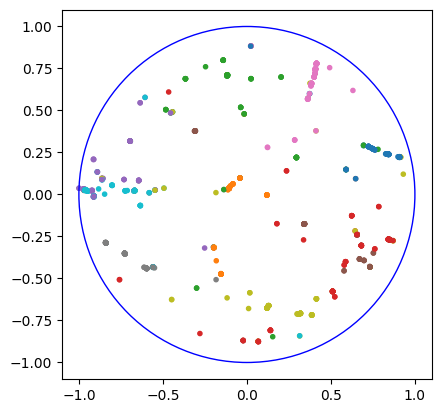

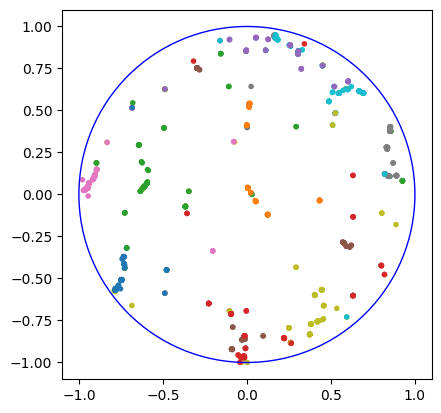

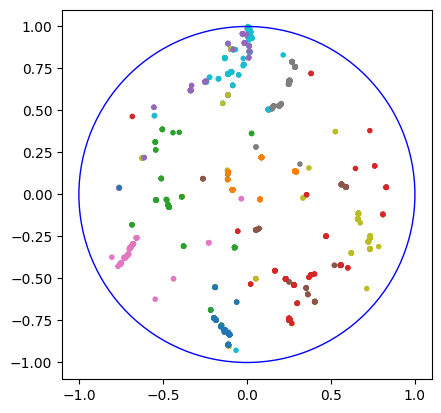

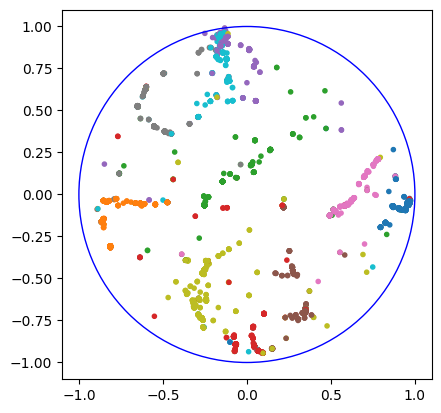

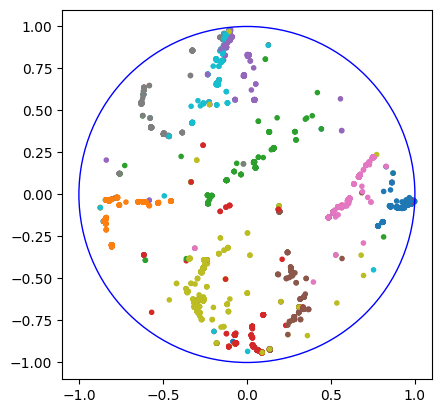

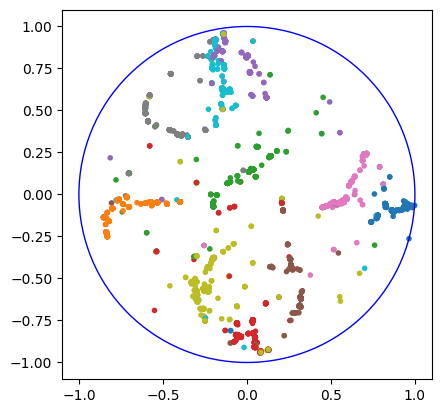

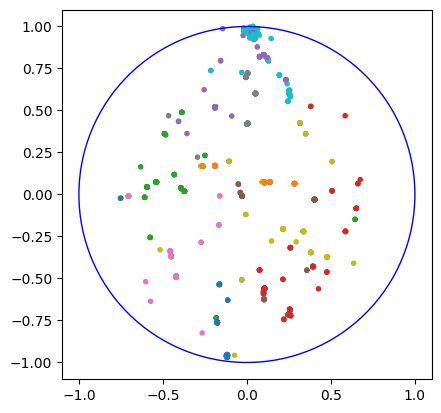

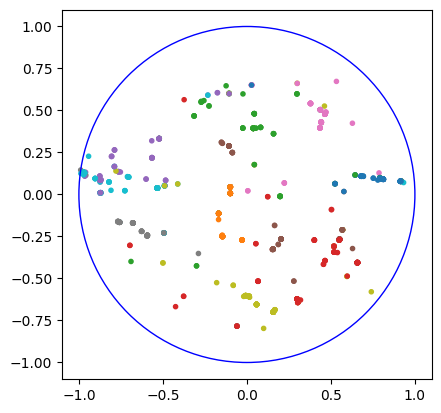

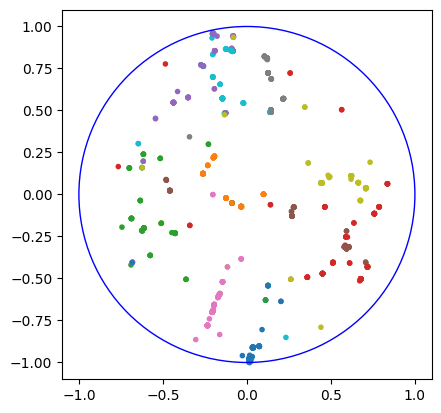

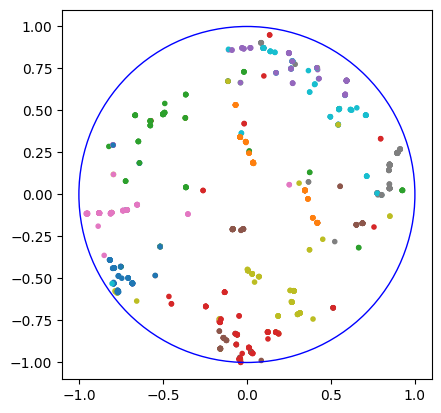

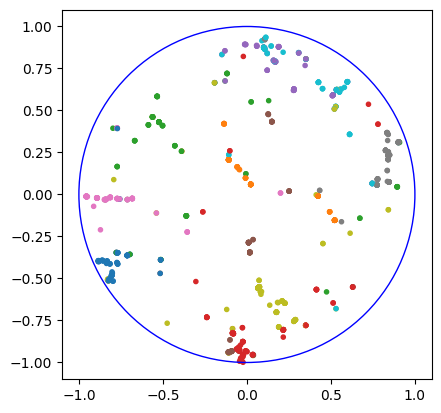

In [3]:
u_grid_ns = [10, 15, 20, 25, 30]
point_counts = [1000, 4000]
#u_grid_ns = [24]

exact_cpu_precisions = []
exact_cpu_recalls = []

exact_gpu_precisions = []
exact_gpu_recalls = []

ugrid_gpu_precisions = []
ugrid_gpu_recalls = []

qtree_cpu_precisions = []
qtree_cpu_recalls = []

for num_points in point_counts:
    #p, r = run(num_points, True, False, 0) # Running exact CPU
    #exact_cpu_precisions.append(p)
    #exact_cpu_recalls.append(r)

    p, r = run(num_points, True, True, 0) # Running exact GPU
    exact_gpu_precisions.append(p)
    exact_gpu_recalls.append(r)

    p, r = run(num_points, False, True, 40) # Running approx. using uniform grid
    ugrid_gpu_precisions.append(p)
    ugrid_gpu_recalls.append(r)

    p, r = run(num_points, False, False, 0) # Running approx. using quadtree
    qtree_cpu_precisions.append(p)
    qtree_cpu_recalls.append(r)

for u_grid_n in u_grid_ns:
    p, r = run(1000, False, True, u_grid_n) # Running approx. using uniform grid
    ugrid_gpu_precisions.append(p)
    ugrid_gpu_recalls.append(r)

Exact CPU:
Precisions: [[0.823, 0.7985, 0.7706666666666666, 0.761, 0.746, 0.7265, 0.7108571428571429, 0.6965, 0.68, 0.6673000000000001, 0.656, 0.6421666666666667, 0.6288461538461539, 0.614, 0.6038, 0.5925625, 0.5818235294117646, 0.5715000000000001, 0.5591052631578947, 0.5484, 0.5390952380952381, 0.5293636363636364, 0.521391304347826, 0.5133333333333333, 0.5022000000000001, 0.49296153846153845, 0.48448148148148146, 0.47557142857142853, 0.4671379310344828, 0.4579], [0.625, 0.60175, 0.58625, 0.572125, 0.5576, 0.546625, 0.5373928571428571, 0.5255625, 0.5158611111111111, 0.507525, 0.49790909090909086, 0.48945833333333333, 0.482, 0.4741071428571429, 0.46748333333333336, 0.459875, 0.45286764705882354, 0.44634722222222223, 0.4397236842105264, 0.4333, 0.42709523809523814, 0.420875, 0.4155217391304348, 0.40871875, 0.40334000000000003, 0.3979038461538461, 0.3924814814814815, 0.3870803571428571, 0.382146551724138, 0.3771749999999999]]
Recalls: [[0.02743333333333333, 0.05323333333333333, 0.07706666

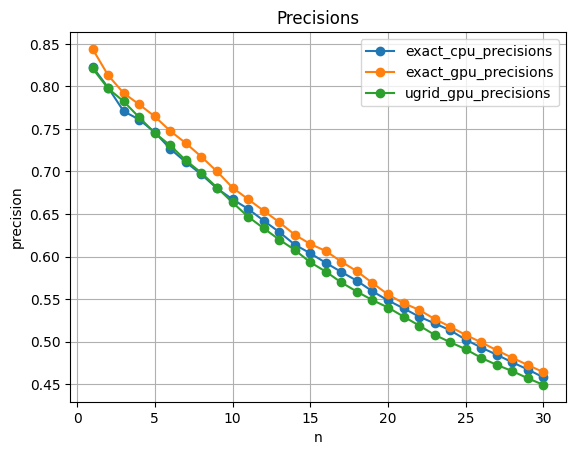

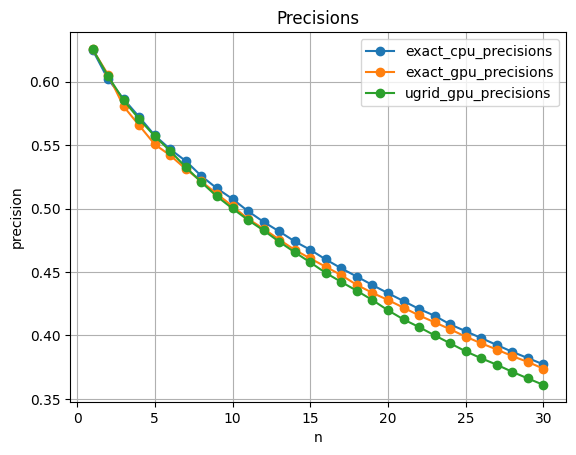

In [17]:
def plot_points(datas, labels, label, x_label, y_label):
    
    for data in datas:
        x = range(1, len(data) + 1)  # x-axis values from 1 to n
        plt.plot(x, data, marker='o', linestyle='-')  # Plot points connected by a line

    plt.legend(labels)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(label)
    plt.grid(True)
    plt.show()

print("Exact CPU:")
print(f"Precisions: {exact_cpu_precisions}")
print(f"Recalls: {exact_cpu_recalls}")

print("Exact GPU:")
print(f"Precisions: {exact_gpu_precisions}")
print(f"Recalls: {exact_gpu_recalls}")

print("Uniform grid:")
print(f"Precisions: {ugrid_gpu_precisions}")
print(f"Recalls: {ugrid_gpu_recalls}")

print("Quadtree:")
print(f"Precisions: {qtree_cpu_precisions}")
print(f"Recalls: {qtree_cpu_recalls}")

data = [exact_cpu_precisions[0], exact_gpu_precisions[0], ugrid_gpu_precisions[0], exact_gpu_precisions[0]]
labels = ["Exact CPU", "Exact GPU", "Uniform grid", "Quadtree"]
plot_points(data, labels, "Precisions", "n", "precision")

data = [exact_cpu_precisions[1], exact_gpu_precisions[1], ugrid_gpu_precisions[1], exact_gpu_precisions[1]]
labels = ["Exact CPU", "Exact GPU", "Uniform grid", "Quadtree"]
plot_points(data, labels, "Precisions", "n", "precision")

data = [exact_gpu_precisions[2], ugrid_gpu_precisions[2], exact_gpu_precisions[2]]
labels = ["Exact GPU", "Uniform grid", "Quadtree"]
plot_points(data, labels, "Precisions", "n", "precision")